In [1]:
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [21]:
class KaggleHouse(d2l.DataModule):
    data_dir = "/home/mikewei/data/datasets"
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.data_dir,
                                                    sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.data_dir,
                                                    sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))
data = KaggleHouse(batch_size=64)
data.raw_train.shape, data.raw_val.shape

((1460, 81), (1459, 80))

In [4]:
data.raw_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [22]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # remove ID and label columns
    label = 'SalePrice'
    features = pd.concat((self.raw_train.drop(columns=['Id', label]),
                          self.raw_val.drop(columns=['Id'])))
    # standardize numeric columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())
    # replace NaN by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # replace discrete by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # save
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()
data.preprocess()
data.train.shape

(1460, 332)

In [29]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float), dtype=torch.float32)
    tensors = (get_tensor(data.drop(columns=[label])), torch.log(get_tensor(data[label])).reshape((-1, 1)))
    return self.get_tensorloader(tensors, train)

In [30]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(fold_size * j, fold_size * (j + 1))
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx), data.train.loc[idx]))
    return rets

def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale = 'log'
        if i != 0: model. board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss) / len(val_loss)}')
    return models

/home/mikewei/anaconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/mikewei/anaconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/mikewei/anaconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/mikewei/anaconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature und

average validation log mse = 0.11886475414037705


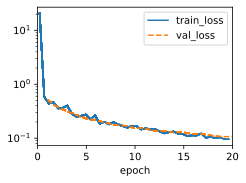

In [31]:
trainer = d2l.Trainer(max_epochs=20)
models = k_fold(trainer, data, k=5, lr=0.01)

In [39]:
get_tensor = lambda x: torch.tensor(x.values.astype(float), dtype=torch.float32)
preds = [model(get_tensor(data.val)) for model in models]
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id': data.raw_val.Id, 'SalePrice': ensemble_preds.detach().numpy()})
submission.to_csv('/tmp/submission.csv', index=False)